# Goal

This notebook...

In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time
# load PI calculation module
from pi import pi

In [2]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

# Load Data

In [3]:
# data location
dat_loc='./data/test_data.nc'
# load and view netcdf file
ds = xr.open_dataset(dat_loc)
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, month: 12, p: 31)
Coordinates:
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 875.0 850.0 825.0 ...
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * month    (month) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    lsm      (lat, lon) float64 ...
    sst      (month, lat, lon) float64 ...
    msl      (month, lat, lon) float64 ...
    t        (month, p, lat, lon) float64 ...
    q        (month, p, lat, lon) float64 ...
    Vmax     (month, lat, lon) float64 ...
    To       (month, lat, lon) float64 ...
    Pmin     (month, lat, lon) float64 ...
    LNB      (month, lat, lon) float64 ...
    PI_flag  (month, lat, lon) float64 ...

In [4]:
# store the data in numpy arrays
SST,MSL,Ta,R,P=np.asarray(ds.sst),np.asarray(ds.msl),np.asarray(ds.t),np.asarray(ds.q),np.asarray(ds.p)

# Calculate PI with Python module

In [5]:
# find the sizes of the the arrays
nlat,nlon=ds.sst.sizes['lat'],ds.sst.sizes['lon']
# create arrays to store data
VMAXp,PMINp,TOp,LNBp=np.zeros((12,nlat,nlon),dtype='float64'),np.zeros((12,nlat,nlon),dtype='float64'), \
    np.zeros((12,nlat,nlon),dtype='float64'),np.zeros((12,nlat,nlon),dtype='float64')
IFLp=np.zeros((12,nlat,nlon),dtype='int64')
# fill with missing data
VMAXp[:],PMINp[:],TOp[:],LNBp[:],IFLp[:]=np.nan,np.nan,np.nan,np.nan,np.nan
# (VMAX,PMIN,IFL,TO,LNB)=pi(sst1,msl1,p1,t1,q1,CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8)

In [6]:
# time the loop
start = time.time()

# loop over the data grid and calculate PI
for m in range(12):
    for x in range(nlon):
        for y in range(nlat):
            #print(x,y,m)
            if (SST[m,y,x]>4.9):
                (VMAXp[m,y,x],PMINp[m,y,x],IFLp[m,y,x],TOp[m,y,x],LNBp[m,y,x]) = pi( \
                    SST[m,y,x],MSL[m,y,x],P,Ta[m,:,y,x],R[m,:,y,x],\
                    CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8)
                #print(VMAXp[m,y,x])
            
    

end = time.time()
print(end - start)

/Users/dgilford/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


843.7375860214233


# Compare Python output to MATLAB output

To validate the output of the pi.py module, we compare it with the MATLAB calculated Potential Intensity code output (provided in the test_data.nc file). We explore the absolute differences, correlations, and the temporal/spatial structures.

## Potential Intensity Maximum Wind (VMAX)

In [70]:
# calculate the difference between Python and MATLAB
diff_VMAX=VMAXp-ds.Vmax

In [72]:
print('VMAX: The maximum absolute difference across all points is '+str(float(abs(diff_VMAX).max())))

VMAX: The maximum absolute difference across all points is 4.109456969558778e-05


#### Spatial Structure

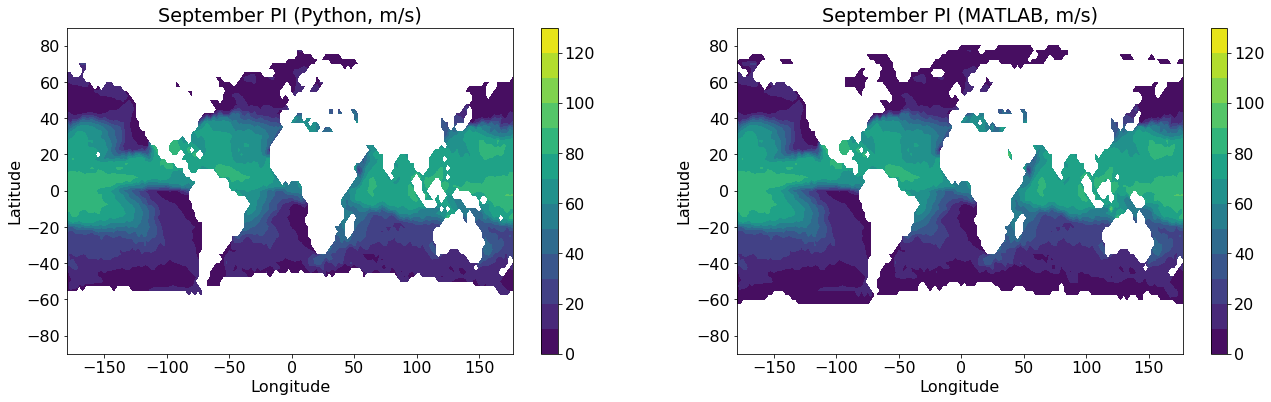

In [88]:
# plot both side by side in September
clevels=np.arange(0,140,10)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,VMAXp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September PI (Python, m/s)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.Vmax.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September PI (MATLAB, m/s)')
plt.colorbar()
plt.show()

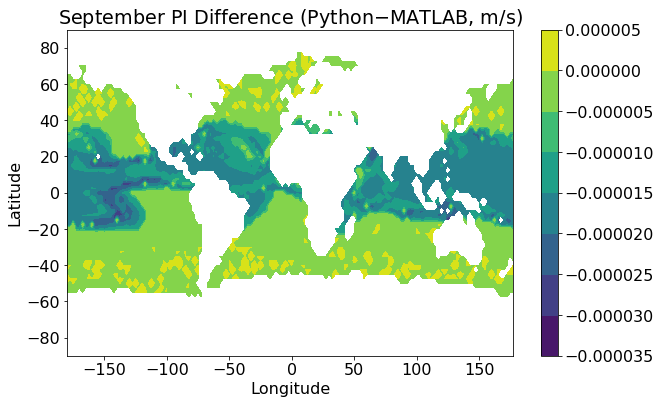

In [68]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_VMAX.isel(month=8))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September PI Difference (Python$-$MATLAB, m/s)')
plt.colorbar()
plt.show()

#### Temporal Structure

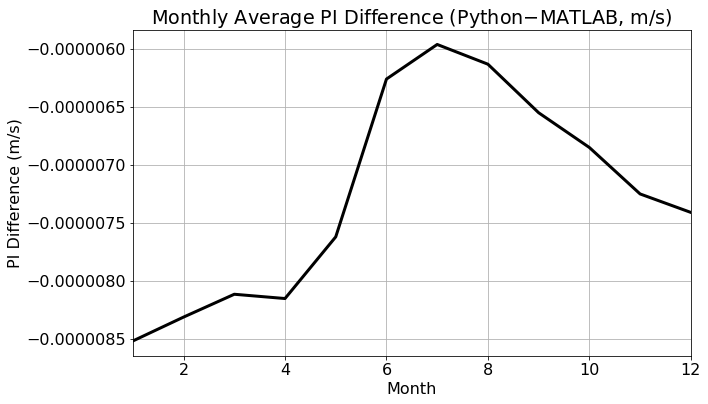

In [103]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_VMAX.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('PI Difference (m/s)')
plt.title('Monthly Average PI Difference (Python$-$MATLAB, m/s)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

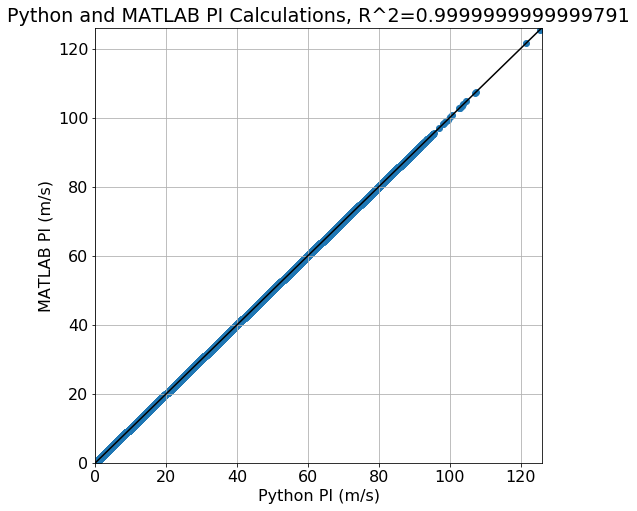

In [139]:
x1=VMAXp[:].flatten()[~np.isnan(VMAXp[:].flatten())]
x2=np.asarray(ds.Vmax)[:].flatten()[~np.isnan(VMAXp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([0,126],[0,126],color='k')
plt.scatter(VMAXp,ds.Vmax)
plt.xlabel('Python PI (m/s)')
plt.ylabel('MATLAB PI (m/s)')
plt.title('Python and MATLAB PI Calculations, R^2='+str(R[0,1]**2))
plt.xlim([0,126])
plt.ylim([0,126])
plt.grid()
plt.show()

## Potential Intensity Minimum Pressure (PMIN)

In [140]:
# calculate the difference between Python and MATLAB
diff_PMIN=PMINp-ds.Pmin

In [141]:
print('PMIN: The maximum absolute difference across all points is '+str(float(abs(diff_PMIN).max())))

PMIN: The maximum absolute difference across all points is 0.0006777920652893954


#### Spatial Structure

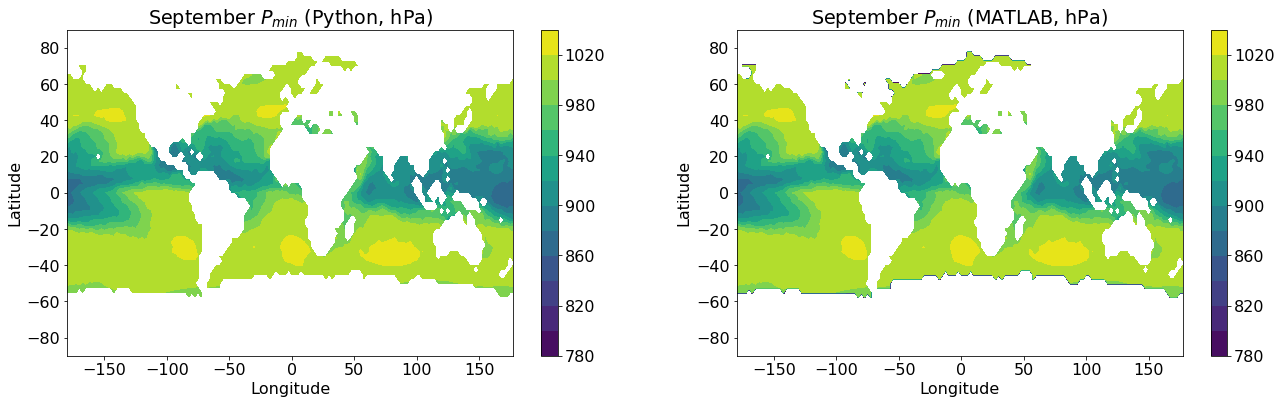

In [162]:
# plot both side by side in September
clevels=np.arange(780,1060,20)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,PMINp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $P_{min}$ (Python, hPa)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.Pmin.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $P_{min}$ (MATLAB, hPa)')
plt.colorbar()
plt.show()

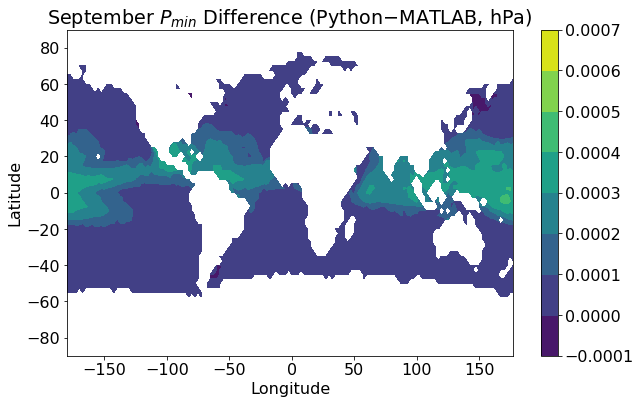

In [163]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_PMIN.isel(month=8))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $P_{min}$ Difference (Python$-$MATLAB, hPa)')
plt.colorbar()
plt.show()

#### Temporal Structure

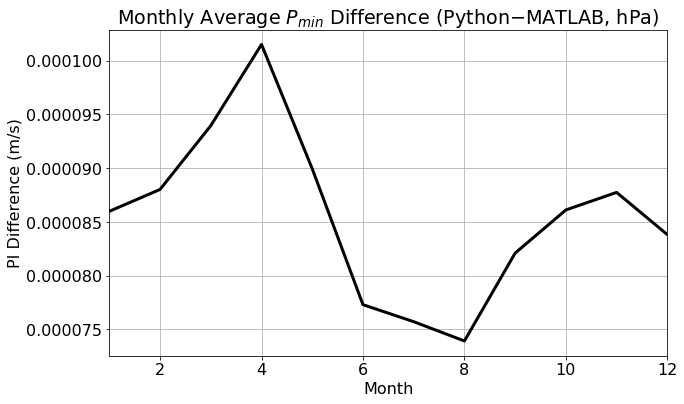

In [164]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_PMIN.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('$P_{min}$ Difference (hPa)')
plt.title('Monthly Average $P_{min}$ Difference (Python$-$MATLAB, hPa)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

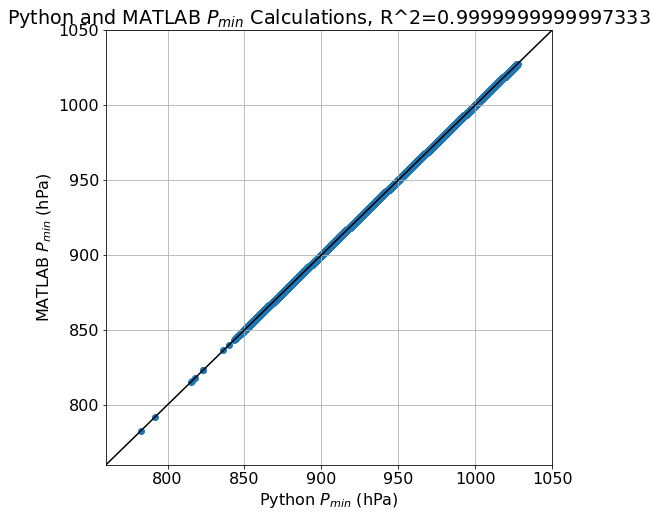

In [169]:
x1=PMINp[:].flatten()[~np.isnan(PMINp[:].flatten())]
x2=np.asarray(ds.Pmin)[:].flatten()[~np.isnan(PMINp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([760,1050],[760,1050],color='k')
plt.scatter(PMINp,ds.Pmin)
plt.xlabel('Python $P_{min}$ (hPa)')
plt.ylabel('MATLAB $P_{min}$ (hPa)')
plt.title('Python and MATLAB $P_{min}$ Calculations, R^2='+str(R[0,1]**2))
plt.xlim([760,1050])
plt.ylim([760,1050])
plt.grid()
plt.show()

## Outflow Temperature

In [172]:
# calculate the difference between Python and MATLAB
diff_To=TOp-ds.To

In [173]:
print('T0: The maximum absolute difference across all points is '+str(float(abs(diff_To).max())))

T0: The maximum absolute difference across all points is 2.7938632541690822e-05


#### Spatial Structure

In [176]:
np.nanmin(TOp)

188.77204734623598

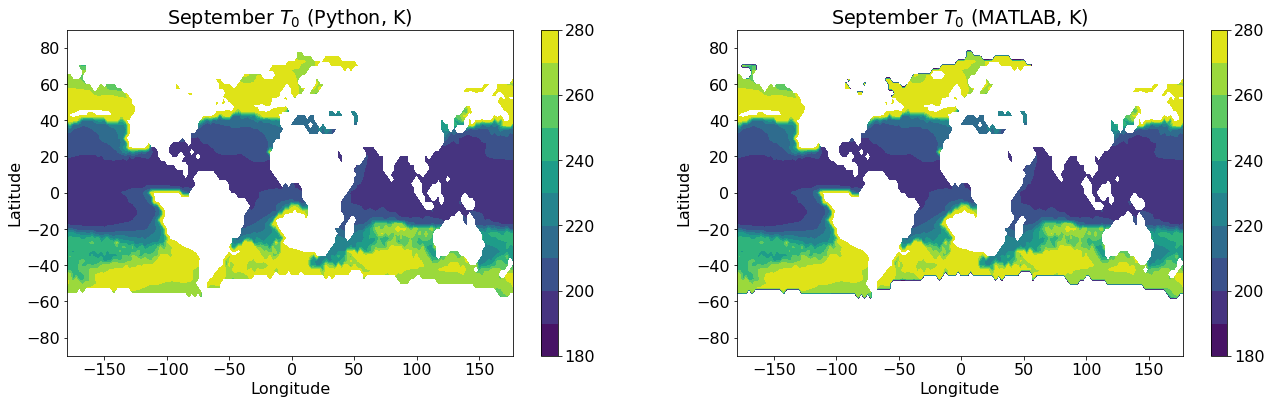

In [181]:
# plot both side by side in September
clevels=np.arange(180,290,10)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,TOp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $T_{0}$ (Python, K)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.To.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $T_{0}$ (MATLAB, K)')
plt.colorbar()
plt.show()

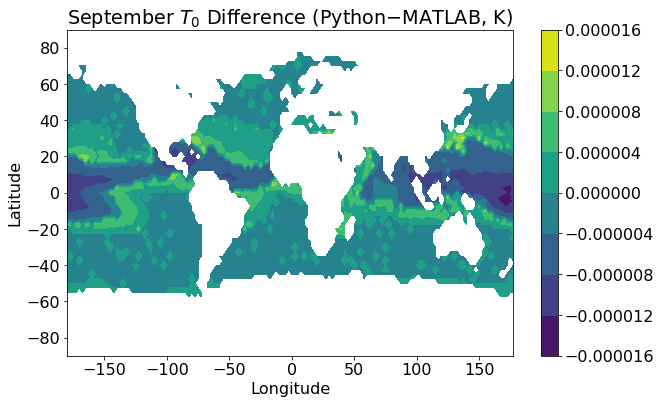

In [180]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_To.isel(month=8))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $T_{0}$ Difference (Python$-$MATLAB, K)')
plt.colorbar()
plt.show()

#### Temporal Structure

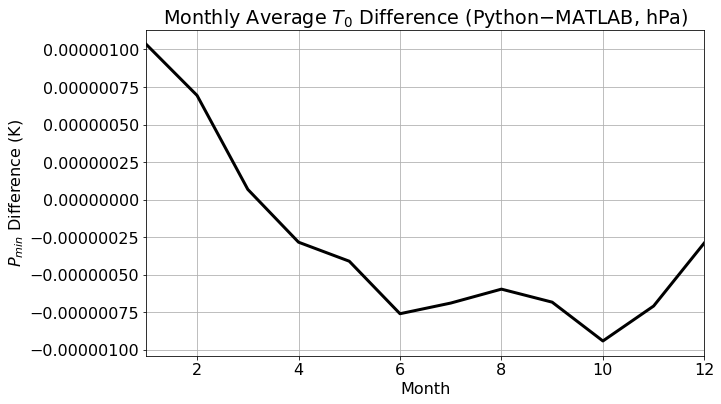

In [197]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_To.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('$P_{min}$ Difference (K)')
plt.title('Monthly Average $T_{0}$ Difference (Python$-$MATLAB, hPa)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

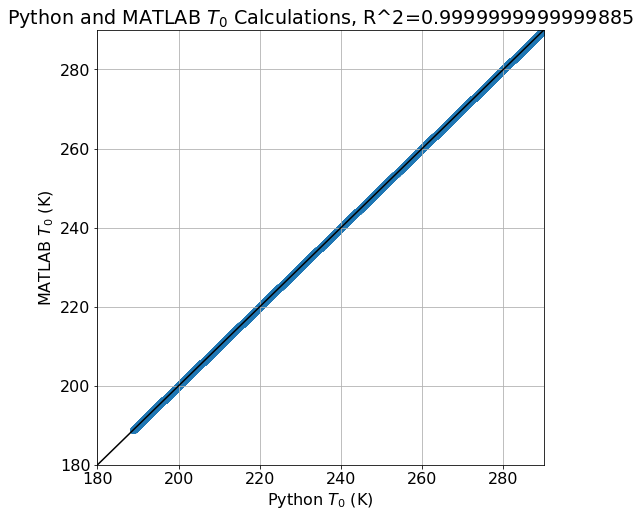

In [186]:
x1=TOp[:].flatten()[~np.isnan(TOp[:].flatten())]
x2=np.asarray(ds.To)[:].flatten()[~np.isnan(TOp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([180,290],[180,290],color='k')
plt.scatter(TOp,ds.To)
plt.xlabel('Python $T_{0}$ (K)')
plt.ylabel('MATLAB $T_{0}$ (K)')
plt.title('Python and MATLAB $T_{0}$ Calculations, R^2='+str(R[0,1]**2))
plt.xlim([180,290])
plt.ylim([180,290])
plt.grid()
plt.show()

## Level of Neutral Buoyancy

In [187]:
# calculate the difference between Python and MATLAB
diff_LNB=LNBp-ds.LNB

In [188]:
print('LNB: The maximum absolute difference across all points is '+str(float(abs(diff_LNB).max())))

LNB: The maximum absolute difference across all points is 1000.0


#### Spatial Structure

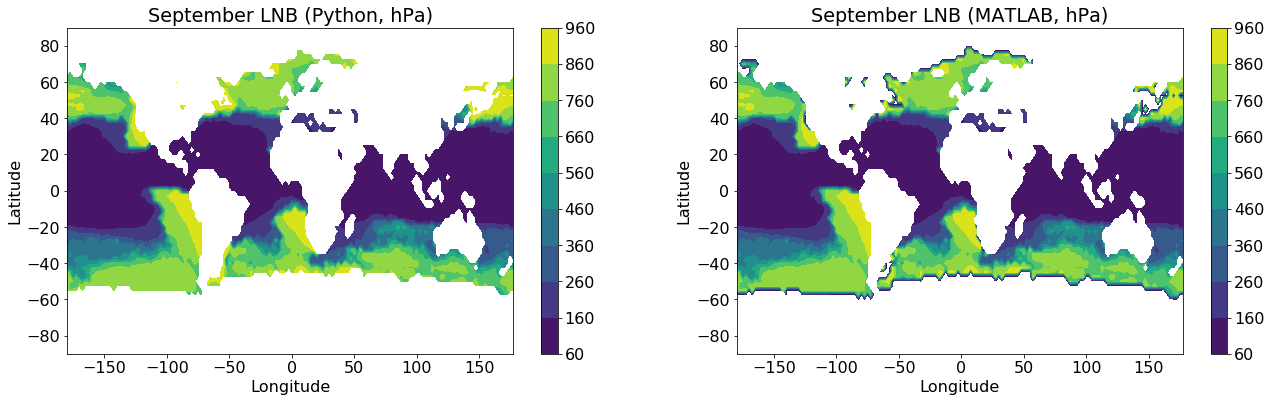

In [195]:
# plot both side by side in September
clevels=np.arange(60,1000,100)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,LNBp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September LNB (Python, hPa)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.LNB.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September LNB (MATLAB, hPa)')
plt.colorbar()
plt.show()

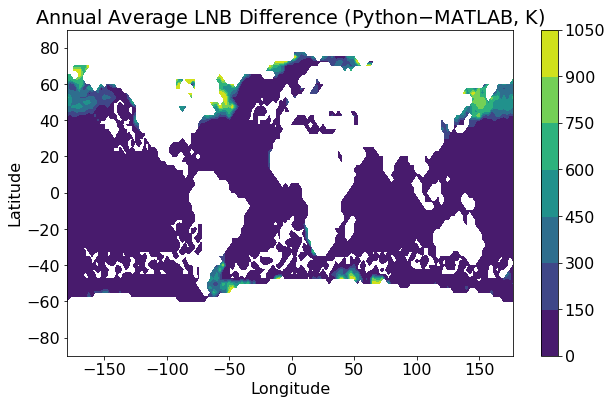

In [215]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_LNB.mean(['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual Average LNB Difference (Python$-$MATLAB, K)')
plt.colorbar()
plt.show()

#### Temporal Structure

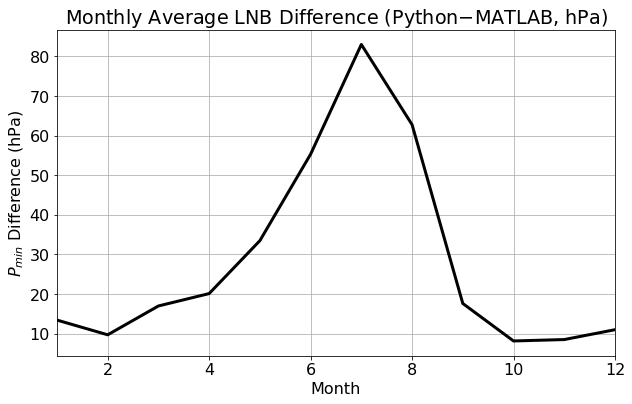

In [198]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_LNB.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('$P_{min}$ Difference (hPa)')
plt.title('Monthly Average LNB Difference (Python$-$MATLAB, hPa)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

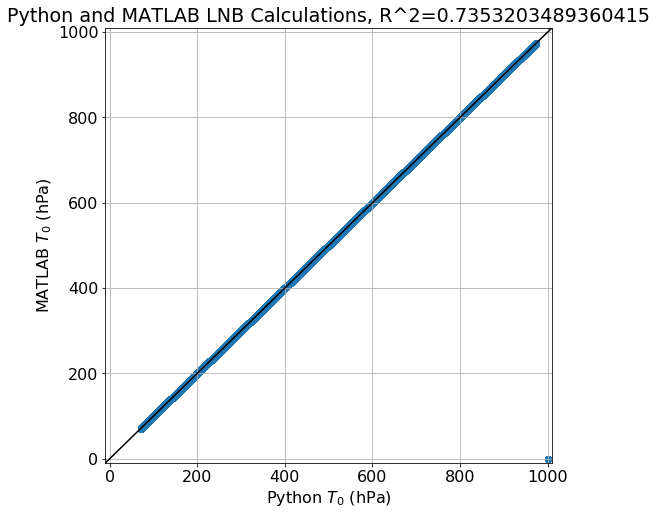

In [208]:
x1=LNBp[:].flatten()[~np.isnan(LNBp[:].flatten())]
x2=np.asarray(ds.LNB)[:].flatten()[~np.isnan(LNBp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([-10,1010],[-10,1010],color='k')
plt.scatter(LNBp,ds.LNB)
plt.xlabel('Python $T_{0}$ (hPa)')
plt.ylabel('MATLAB $T_{0}$ (hPa)')
plt.title('Python and MATLAB LNB Calculations, R^2='+str(R[0,1]**2))
plt.xlim([-10,1010])
plt.ylim([-10,1010])
plt.grid()
plt.show()

We note that while there are *some* differences between the LNB calculations, they are all at higher latitudes, where the Python script tends to have LNB=1000 when the MATLAB script assigned 0.

In [216]:
NEED TO CHECK FLAG NEXT!

SyntaxError: invalid syntax (<ipython-input-216-91908f812812>, line 1)

In [11]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

inputs = range(10) 
def processInput(i):
    return i * i

num_cores = multiprocessing.cpu_count()

results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
print(results)